# Mulberry Leaf: Cross-Validation on MobileNetV2SE
### ***Dataset: Mulberry Leaf Dataset https://www.kaggle.com/datasets/nahiduzzaman13/mulberry-leaf-dataset [No Preprocessing]***

In [1]:
import pandas as pd
import numpy as np
import shutil
import zipfile
from functools import reduce
from datetime import datetime
from os import path, makedirs, remove, environ, listdir
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, roc_curve, auc

import tensorflow as tf

# Set environment variable to suppress TensorFlow's lower-level logs
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Multiply, Activation, GlobalAveragePooling2D, Multiply, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall


from tensorflow.keras import mixed_precision
# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

plt.rcParams['font.family'] = 'serif'            # Use a specific font
plt.rcParams['font.size'] = 14                   # Set a general font size


In [2]:
def imshow(imgs, titles=None):
    '''Utility class for showing images.'''
    r, c = 3, 4
    plt.figure(figsize=(16, 12))
    for idx in range(1, min(r*c, len(imgs))+1):
        plt.subplot(r, c, idx)
        plt.axis('off')
        if titles != None and idx-1 < len(titles):
            plt.title(titles[idx-1])
        plt.imshow(imgs[idx-1], cmap='plasma')    
    plt.show()

def se_block(x, ratio=8):
    """Contains the implementation of Squeeze-and-Excitation(SE) block.
    As described in https://arxiv.org/abs/1709.01507.
    """
    num_channels = K.int_shape(x)[-1]

    se = GlobalAveragePooling2D(name='block_se_GAP')(x)
    se = Reshape((1, 1, num_channels), name='block_se_reshape')(se)
    se = Dense(num_channels // ratio, 
                      name='block_se_dense_1', 
                      activation='relu',
                      kernel_initializer='he_normal',
                      use_bias=True,
                      bias_initializer='zeros')(se)
    se = Dense(num_channels,
                      name='block_se_dense_2', 
                      activation='sigmoid',
                      kernel_initializer='he_normal',
                      use_bias=True,
                      bias_initializer='zeros')(se)

    return Multiply(name='block_se_multiply')([x, se])

def process_image(image, label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

def get_predictions(model, ds):
    y_true, y_pred = [], []
    for images, labels in ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    true_labels = np.argmax(y_true, axis=1)
    pred_labels = np.argmax(y_pred, axis=1)
    
    return y_true, y_pred, true_labels, pred_labels

def plot_roc_auc(y_true, y_pred, num_classes, display_labels, title=None):
    class_auc_lst = []
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        # One-vs-rest for class `i`
        y_true_class = [y[i] for y in y_true]
        y_pred_class = [y[i] for y in y_pred]
        
        fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
        class_auc = auc(fpr, tpr)
        class_auc_lst.append(class_auc)
        
        # Plot ROC curve for each class
        plt.plot(fpr, tpr, label=f'{display_labels[i]} (AUC = {class_auc:.4f})')
    
    # Finalize and display plot
    plt.plot([0, 1], [0, 1], color='r', linestyle='--', lw=2)
    plt.title('ROC Curve' if not title else title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
    
    return class_auc_lst


# 1. Fetch Dataset

In [3]:
ROOT_INPUT_DIR = '/kaggle/input/mblf-dataprep/'
ROOT_OUTPUT_DIR = '/kaggle/working/'

NEW_DATA_DIR = path.join(ROOT_OUTPUT_DIR, 'data')
TRAIN_DIR = path.join(ROOT_OUTPUT_DIR, 'data/train')
TEST_DIR = path.join(ROOT_OUTPUT_DIR, 'data/test')

IMG_SIZE = 224
BATCH_SIZE = 64
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
EPOCHS = 80
LEARNING_RATE = 1e-5

TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
N_FOLDS = 5
DISPLAY_LABELS = ['Disease Free', 'Leaf Rust', 'Leaf Spot']


In [4]:
## Fresh data from storage
#
# Clean up older files
_path_to_temp_model = path.join(ROOT_OUTPUT_DIR, 'model_temp.keras')
if path.exists(_path_to_temp_model):
    remove(_path_to_temp_model)
    print('Deleted:', _path_to_temp_model)

if path.exists(NEW_DATA_DIR):
    shutil.rmtree(NEW_DATA_DIR, ignore_errors=True)
    print('Deleted:', NEW_DATA_DIR)


# 2. Construct Model

In [5]:
def build_model_mobilenetv2se(lr=LEARNING_RATE):
    # Load base model without the top layer
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
    # Add custom layers
    x = base_model.get_layer('block_7_expand_relu').output
    x = se_block(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3)(x)  # 3 classes
    op = Activation('softmax', dtype='float32')(x)

    # Create the new model
    model = Model(name='MobileNetV2SE', inputs=base_model.input, outputs=op)
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy', 
            Precision(name='precision'), 
            Recall(name='recall')
        ]
    )

    return model


In [6]:
## Show summary

build_model_mobilenetv2se().summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2SE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 145,523 (568.45 KB)

 Trainable params: 140,339 (548.20 KB)

 Non-trainable params: 5,184 (20.25 KB)

# 3. Train & Evaluate

In [7]:
score_lst = []
df_lst = []
cm_lst = []
f1_lst = []
all_y_true = []
all_y_pred = []

for i in range(N_FOLDS):
    print('================================================================================')
    print(f'Fold #{i+1}')
    print('================================================================================')
    _fold_str = f'fold{i+1}'
    
    # Unzipping
    _path_to_zip_file = path.join(
        ROOT_INPUT_DIR, 'data', _fold_str+'.zip'
    )
    makedirs(NEW_DATA_DIR, exist_ok=True)
    with zipfile.ZipFile(_path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(NEW_DATA_DIR)
        print(f'Extracted {_fold_str} from {_path_to_zip_file}')
    
    # Prepare tensorflow datasets
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR,
        color_mode='rgb',
        seed=1234, 
        label_mode="categorical", 
        image_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE
    )
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR,
        color_mode='rgb',
        seed=1234, 
        label_mode="categorical", 
        image_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE
    )
    train_ds = train_ds.map(process_image)
    test_ds = test_ds.map(process_image)

    # Compile model
    model = build_model_mobilenetv2se()
    
    # Training
    cb = [
        ModelCheckpoint(filepath=path.join(ROOT_OUTPUT_DIR, 'model_temp.keras'), monitor='val_accuracy', mode='max', save_best_only=True)
    ]
    history = model.fit(train_ds, callbacks=cb, validation_data=test_ds, epochs=EPOCHS, verbose=2)
    
    # Saving
    MODEL_SAVE_PATH = path.join(ROOT_OUTPUT_DIR, f'model_mblf_mobilenetv2se_{TIMESTAMP}_{_fold_str}.keras')
    HISTORY_SAVE_PATH = path.join(ROOT_OUTPUT_DIR, f'history_mblf_mobilenetv2se_{TIMESTAMP}_{_fold_str}.csv')
    shutil.move(path.join(ROOT_OUTPUT_DIR, 'model_temp.keras'), MODEL_SAVE_PATH)
    print('\nModel saved in:', MODEL_SAVE_PATH)
    
    # Save the history to a CSV file
    df = pd.DataFrame(history.history)
    df_lst.append(df)
    df.to_csv(HISTORY_SAVE_PATH)
    print('History saved in:', HISTORY_SAVE_PATH)
    print('')

    # Load again and evaluate
    saved_model = load_model(MODEL_SAVE_PATH)
    score = saved_model.evaluate(test_ds, verbose=0)
    score_lst.append(score)

    # Confusion matrix + F1 Score + AUC-ROC
    y_true, y_pred, true_labels, pred_labels = get_predictions(model=saved_model, ds=test_ds)
    
    cf_matrix = confusion_matrix(true_labels, pred_labels)
    cm_lst.append(cf_matrix)
    f1 = f1_score(true_labels, pred_labels, average='micro')
    f1_lst.append(f1)
    all_y_true.append(y_true)
    all_y_pred.append(y_pred)
    
    print(classification_report(true_labels, pred_labels, target_names=DISPLAY_LABELS))
    print('')
    
    # Cleaning
    shutil.rmtree(NEW_DATA_DIR)
    pass


Fold #1
Extracted fold1 from /kaggle/input/mblf-dataprep/data/fold1.zip
Found 7517 files belonging to 3 classes.
Found 219 files belonging to 3 classes.
Epoch 1/80


I0000 00:00:1733764265.264221      63 service.cc:145] XLA service 0x7f3e5c004a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733764265.264306      63 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733764285.035771      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/118 - 58s - 493ms/step - accuracy: 0.3795 - loss: 1.4687 - precision: 0.3857 - recall: 0.3202 - val_accuracy: 0.4658 - val_loss: 1.1938 - val_precision: 0.4628 - val_recall: 0.3973
Epoch 2/80
118/118 - 7s - 63ms/step - accuracy: 0.4628 - loss: 1.1233 - precision: 0.4917 - recall: 0.3388 - val_accuracy: 0.4795 - val_loss: 0.9134 - val_precision: 0.8788 - val_recall: 0.2648
Epoch 3/80
118/118 - 7s - 63ms/step - accuracy: 0.5704 - loss: 0.9235 - precision: 0.6289 - recall: 0.4354 - val_accuracy: 0.8128 - val_loss: 0.7718 - val_precision: 0.9720 - val_recall: 0.4749
Epoch 4/80
118/118 - 7s - 61ms/step - accuracy: 0.6734 - loss: 0.7536 - precision: 0.7415 - recall: 0.5573 - val_accuracy: 0.6849 - val_loss: 0.6945 - val_precision: 0.7933 - val_recall: 0.5434
Epoch 5/80
118/118 - 7s - 62ms/step - accuracy: 0.7656 - loss: 0.6033 - precision: 0.8224 - recall: 0.6794 - val_accuracy: 0.5525 - val_loss: 0.7106 - val_precision: 0.6145 - val_recall: 0.5023
Epoch 6/80
118/118 - 7s - 61ms/step - a

# 4. Display Results


Results for Fold #1:
----------------------------------------
Loss       : 0.115679
Accuracy   : 0.977169
Precision  : 0.977169
Recall     : 0.977169
F1 Score   : 0.977169


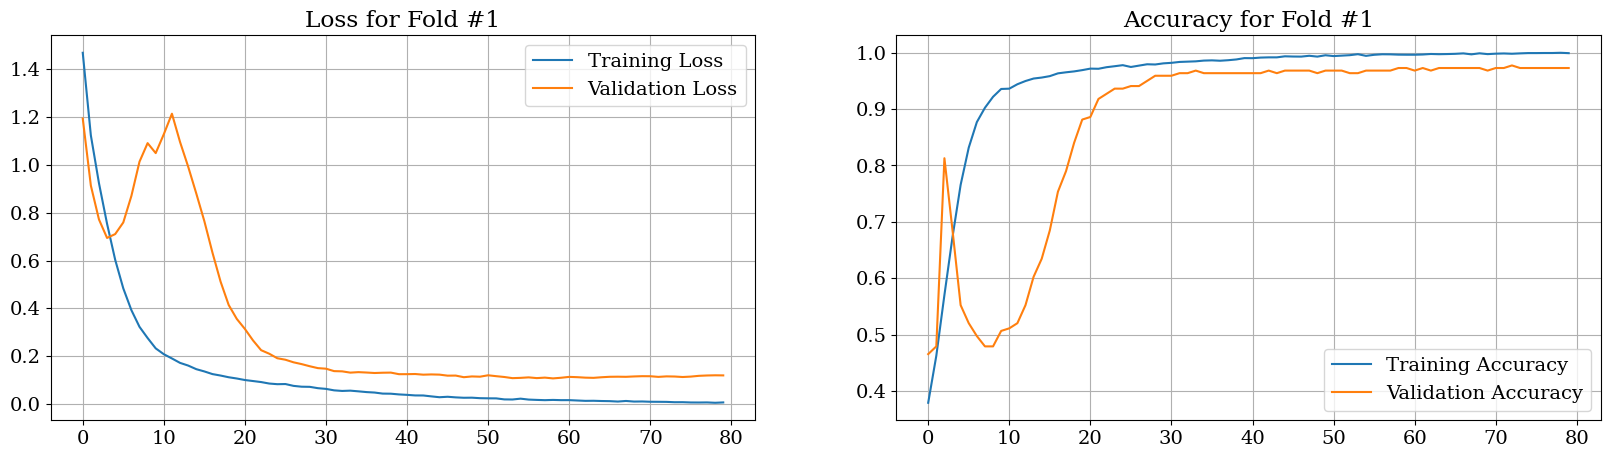

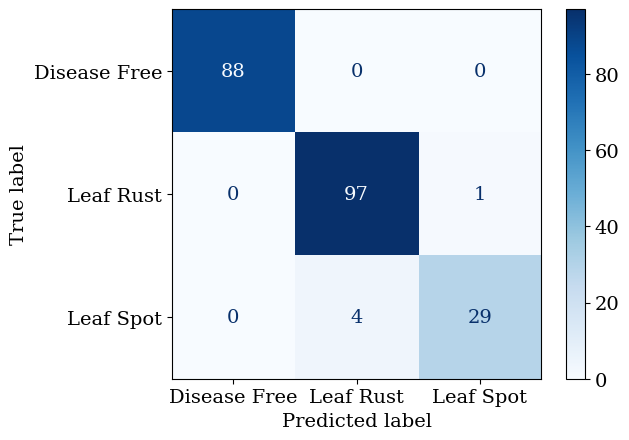

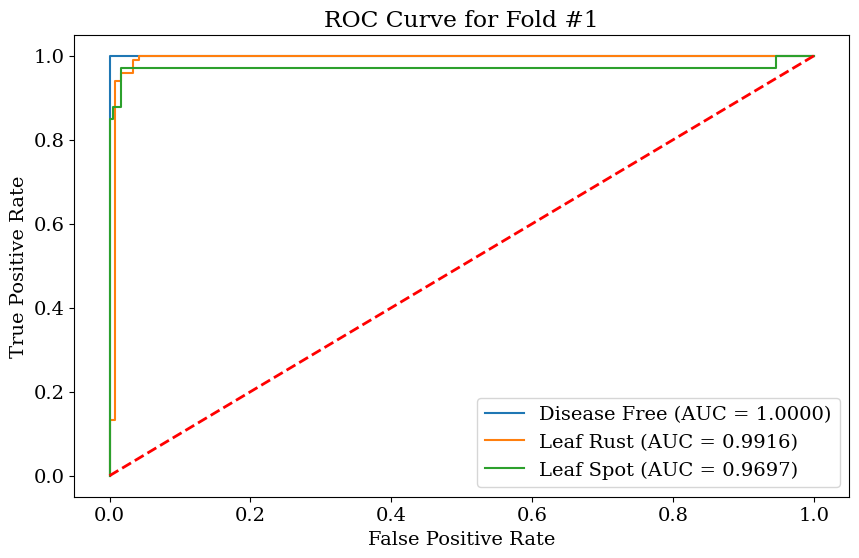

AUC for Disease Free   : 1.000000
AUC for Leaf Rust      : 0.991567
AUC for Leaf Spot      : 0.969697


Results for Fold #2:
----------------------------------------
Loss       : 0.076944
Accuracy   : 0.986239
Precision  : 0.986239
Recall     : 0.986239
F1 Score   : 0.986239


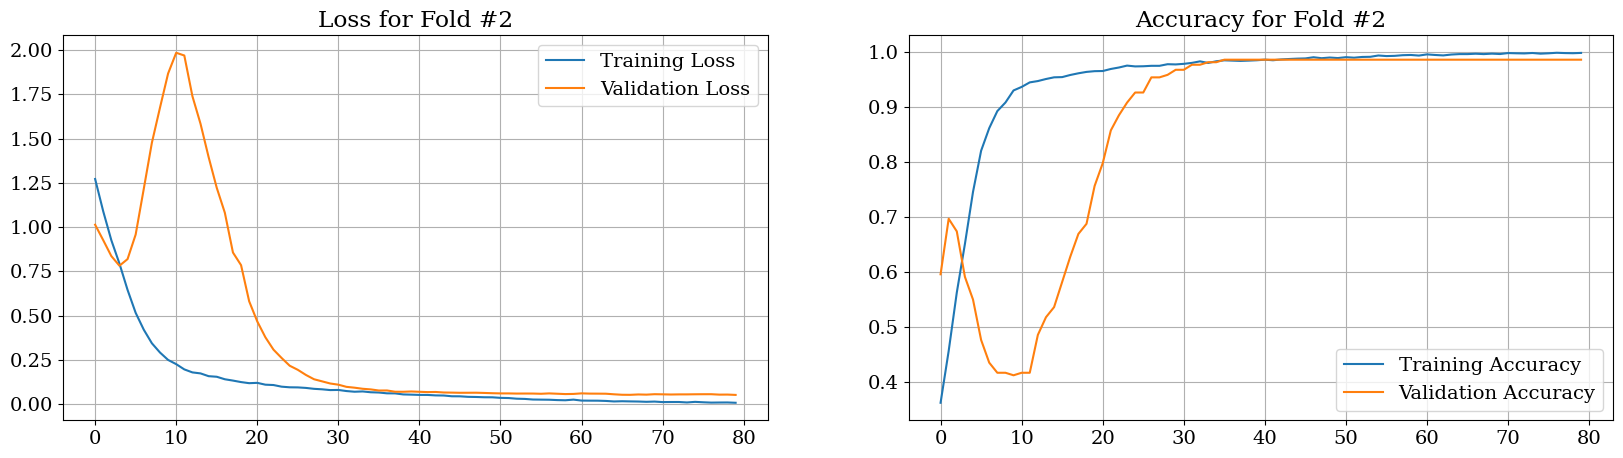

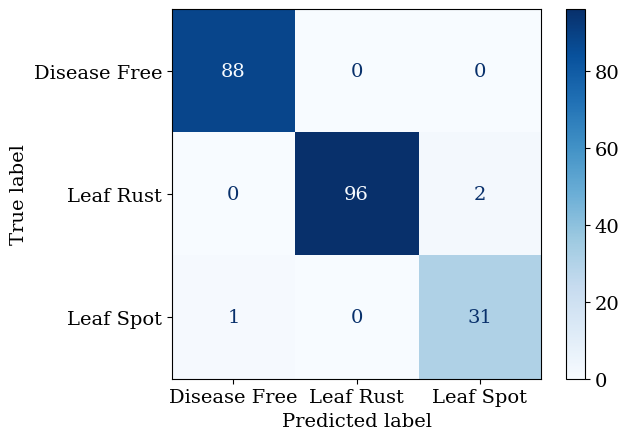

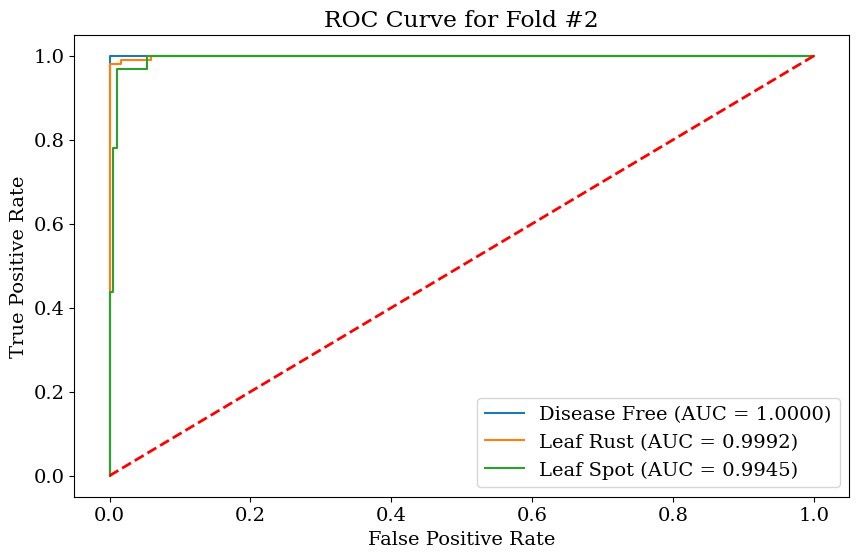

AUC for Disease Free   : 1.000000
AUC for Leaf Rust      : 0.999235
AUC for Leaf Spot      : 0.994456


Results for Fold #3:
----------------------------------------
Loss       : 0.041763
Accuracy   : 0.990826
Precision  : 0.990783
Recall     : 0.986239
F1 Score   : 0.990826


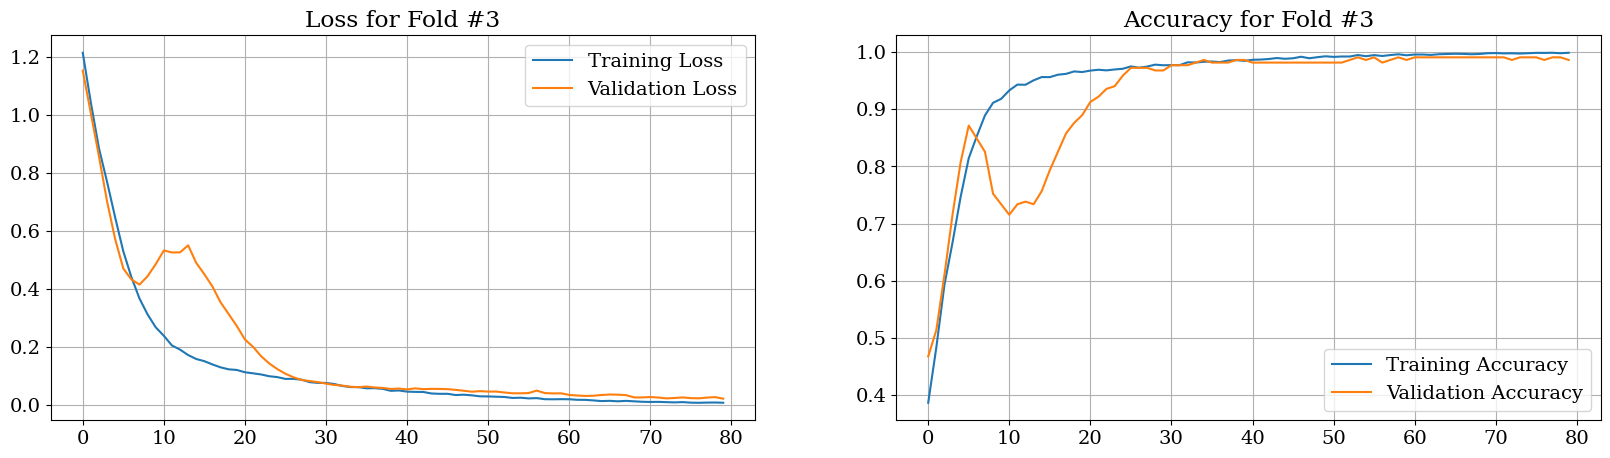

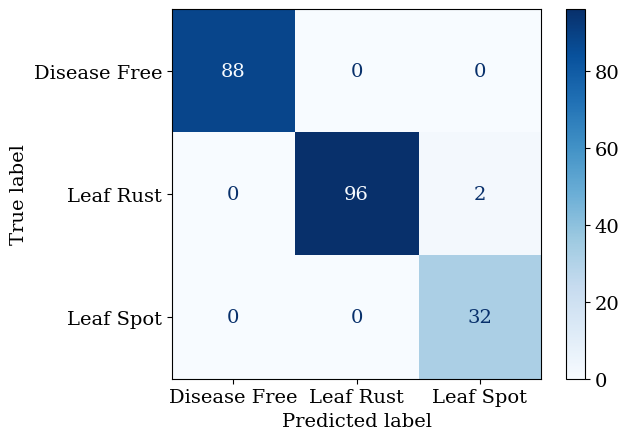

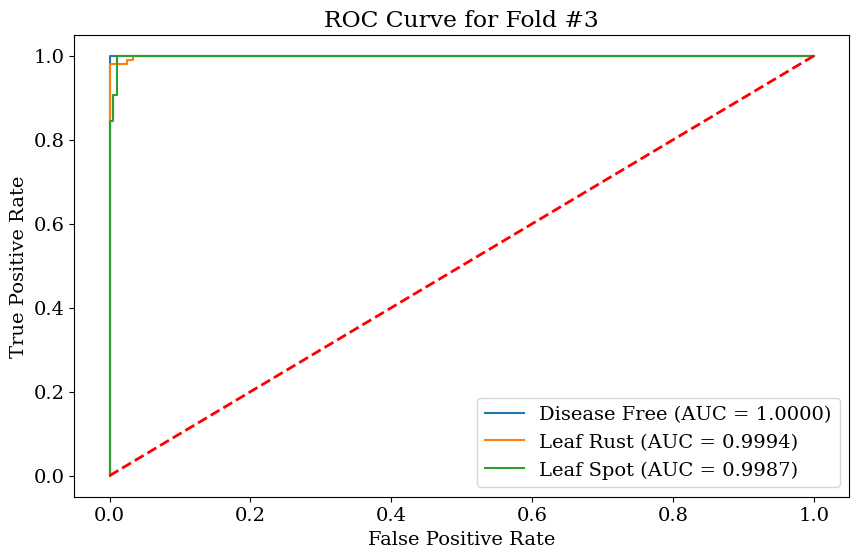

AUC for Disease Free   : 1.000000
AUC for Leaf Rust      : 0.999405
AUC for Leaf Spot      : 0.998656


Results for Fold #4:
----------------------------------------
Loss       : 0.046054
Accuracy   : 0.986239
Precision  : 0.986239
Recall     : 0.986239
F1 Score   : 0.986239


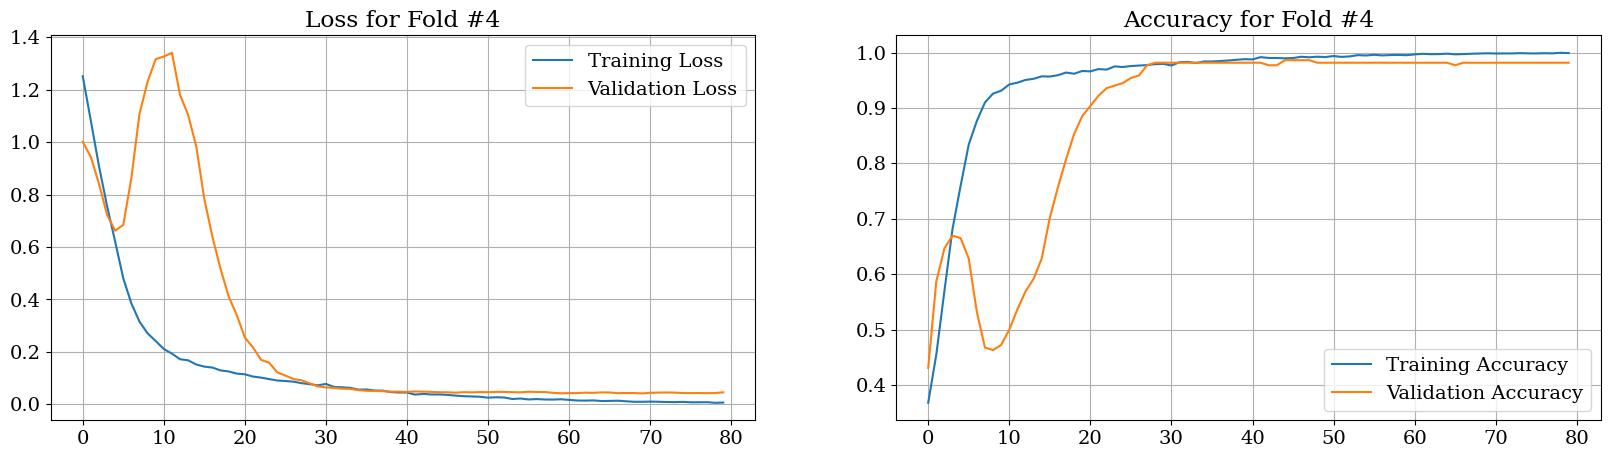

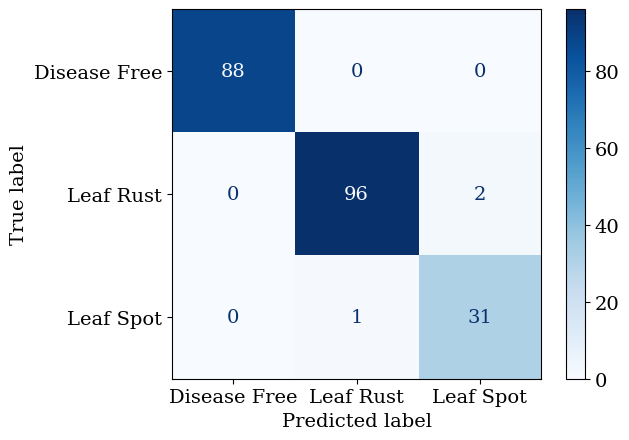

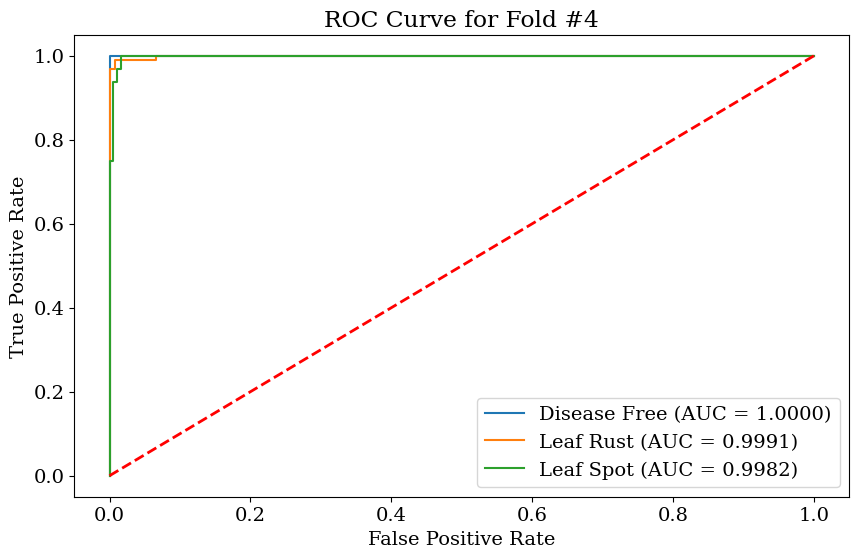

AUC for Disease Free   : 1.000000
AUC for Leaf Rust      : 0.999150
AUC for Leaf Spot      : 0.998152


Results for Fold #5:
----------------------------------------
Loss       : 0.035615
Accuracy   : 0.990826
Precision  : 0.990826
Recall     : 0.990826
F1 Score   : 0.990826


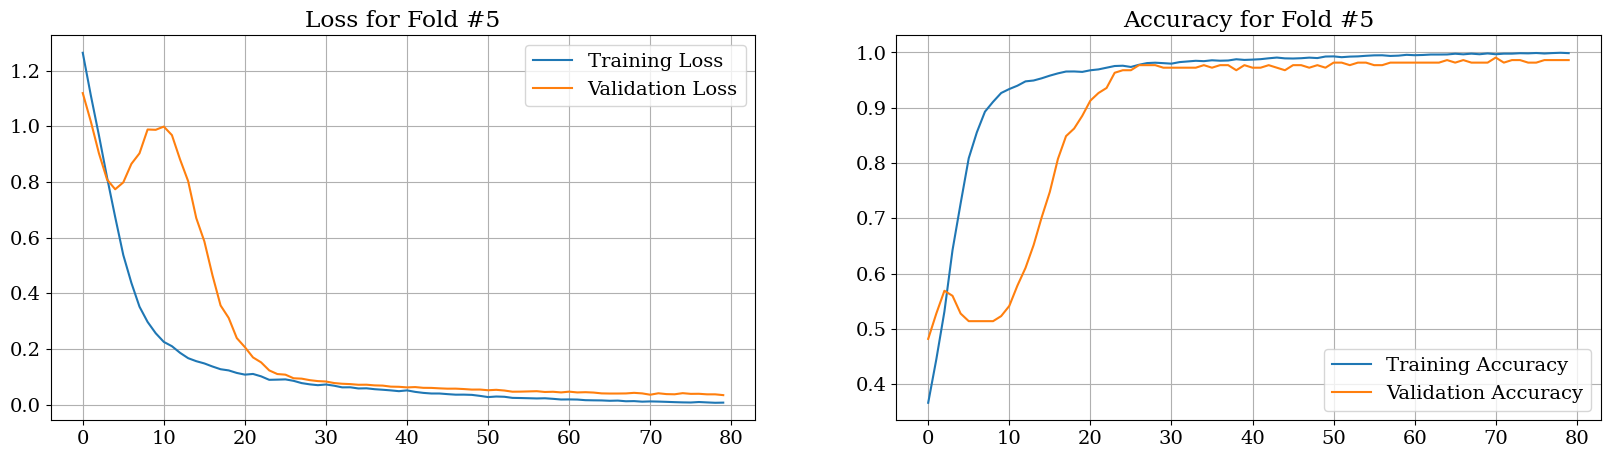

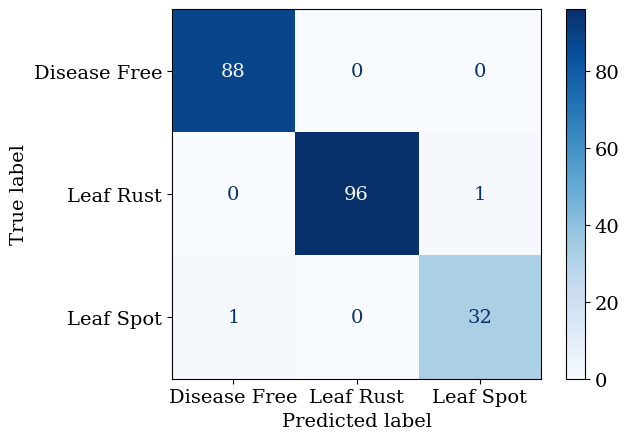

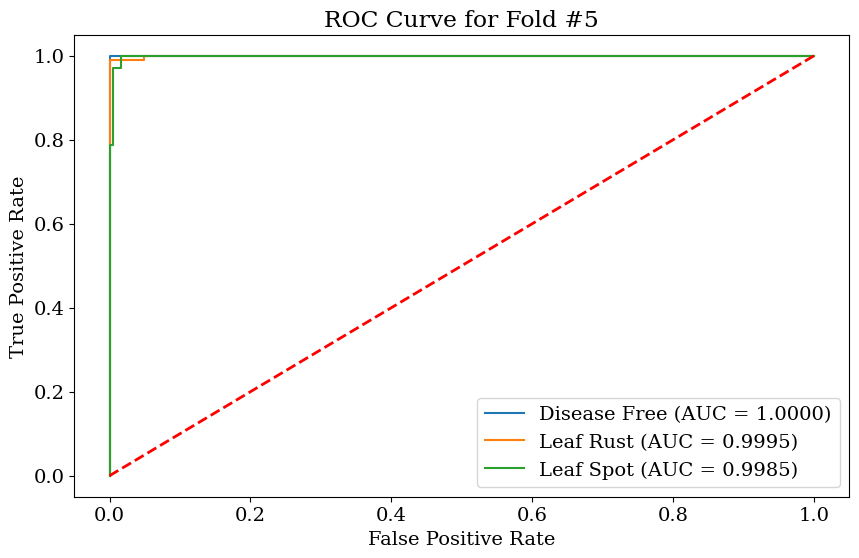

AUC for Disease Free   : 1.000000
AUC for Leaf Rust      : 0.999489
AUC for Leaf Spot      : 0.998526



In [8]:
for idx in range(N_FOLDS):
    _fold_str = f'Fold #{idx+1}'

    # Print individual test results
    print(f'\nResults for {_fold_str}:')
    print('----------------------------------------')
    print(f'Loss       : {score_lst[idx][0]:.6f}')
    print(f'Accuracy   : {score_lst[idx][1]:.6f}')
    print(f'Precision  : {score_lst[idx][2]:.6f}')
    print(f'Recall     : {score_lst[idx][3]:.6f}')
    print(f'F1 Score   : {f1_lst[idx]:.6f}')

    # Plot individual training curves
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1,2,1)
    plt.plot(df_lst[idx].loss, label='Training Loss')
    plt.plot(df_lst[idx].val_loss, label='Validation Loss')
    plt.title("Loss for "+_fold_str)
    plt.grid()
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(df_lst[idx].accuracy, label='Training Accuracy')
    plt.plot(df_lst[idx].val_accuracy, label='Validation Accuracy')
    plt.title("Accuracy for "+_fold_str)
    plt.grid()
    plt.legend()
    plt.show()
    
    # Plot individual confusion matrix
    cmd = ConfusionMatrixDisplay(cm_lst[idx], display_labels=DISPLAY_LABELS)
    cmd.plot(cmap='Blues')
    plt.show()
    
    # Plot ROC and AUC for each class
    cls_auc_lst = plot_roc_auc(all_y_true[idx], all_y_pred[idx], num_classes=3, display_labels=DISPLAY_LABELS, title=f'ROC Curve for Fold #{idx+1}')
    for i, cls_auc in enumerate(cls_auc_lst):
        print(f'AUC for {DISPLAY_LABELS[i]:<15}: {cls_auc:.6f}')
    
    print('')
    pass


Cross-Validation Results:
----------------------------------------
Average Loss       : 0.063211
Average Accuracy   : 0.986259
Average Precision  : 0.986251
Average Recall     : 0.985342
Average F1 Score   : 0.986259


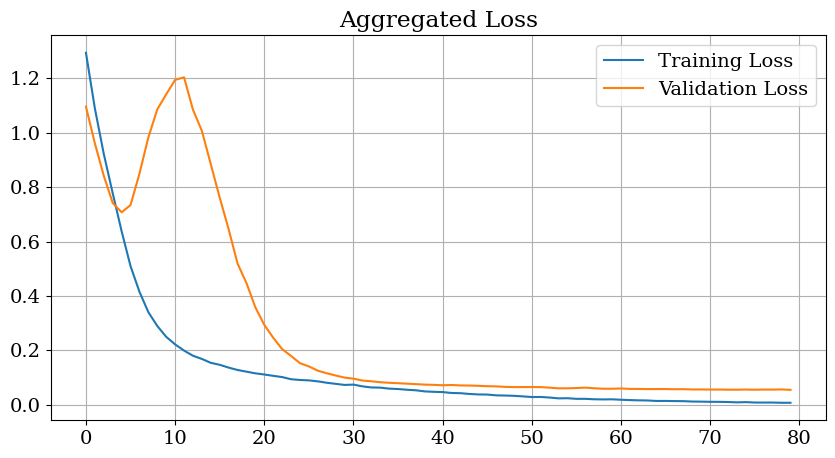

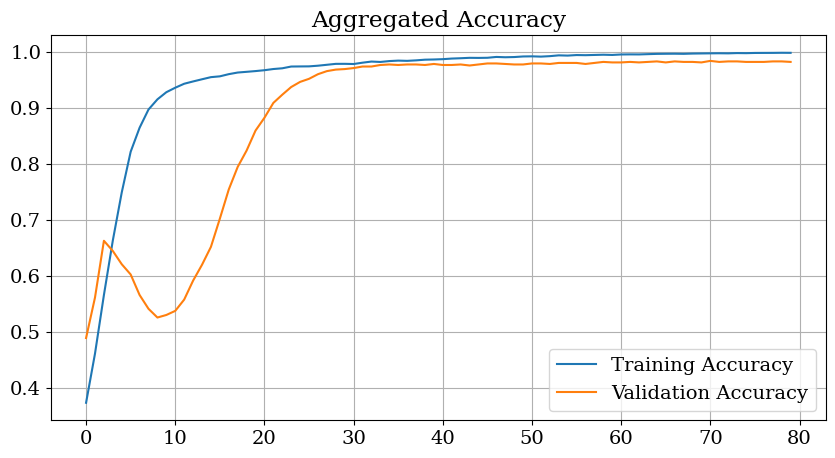

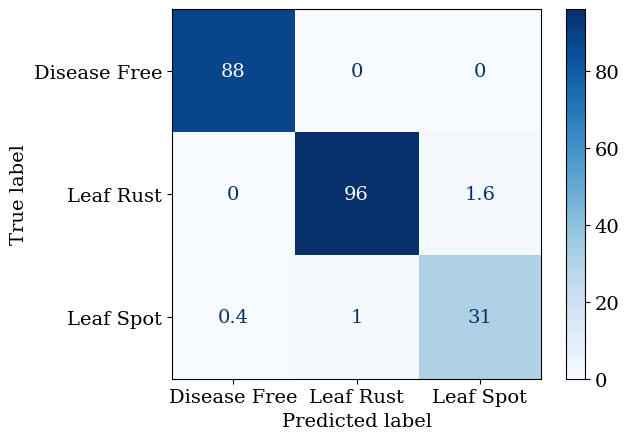

In [9]:
# Aggregate results
avg_score = np.mean(score_lst, axis=0)
avg_f1 = np.mean(f1_lst, axis=0)
avg_df = reduce(lambda a, b: a.add(b, fill_value=0), df_lst) / 5.0
avg_cm = np.mean(cm_lst, axis=0)
all_y_true = np.concatenate(all_y_true, axis=0)
all_y_pred = np.concatenate(all_y_pred, axis=0)

# Print aggregated test results
print('Cross-Validation Results:')
print('----------------------------------------')
print(f'Average Loss       : {avg_score[0]:.6f}')
print(f'Average Accuracy   : {avg_score[1]:.6f}')
print(f'Average Precision  : {avg_score[2]:.6f}')
print(f'Average Recall     : {avg_score[3]:.6f}')
print(f'Average F1 Score   : {avg_f1:.6f}')

# Plot aggregated training curves
plt.figure(figsize=(10, 5))
plt.plot(avg_df.loss, label='Training Loss')
plt.plot(avg_df.val_loss, label='Validation Loss')
plt.title("Aggregated Loss")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(avg_df.accuracy, label='Training Accuracy')
plt.plot(avg_df.val_accuracy, label='Validation Accuracy')
plt.title("Aggregated Accuracy")
plt.grid()
plt.legend()
plt.show()

# Plot aggregated confusion matrix
cmd = ConfusionMatrixDisplay(avg_cm, display_labels=DISPLAY_LABELS)
cmd.plot(cmap='Blues')
plt.show()

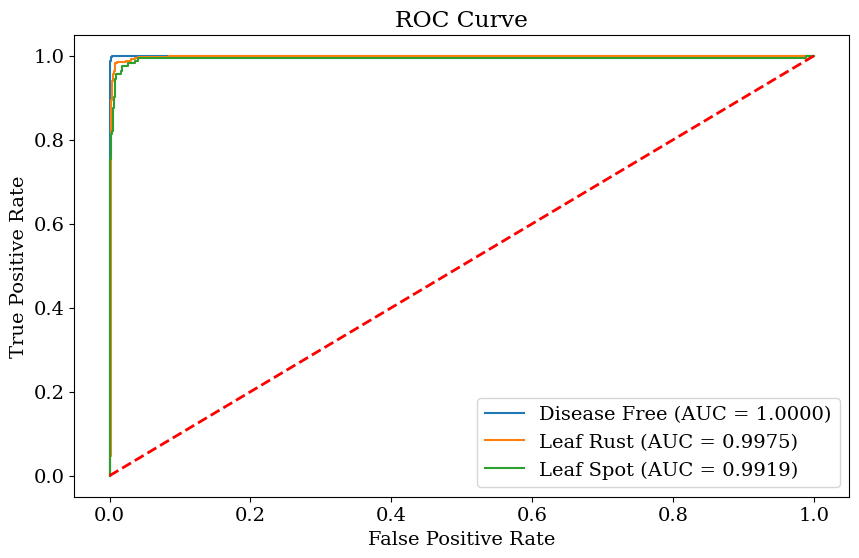

AUC for Disease Free   : 0.999976
AUC for Leaf Rust      : 0.997500
AUC for Leaf Spot      : 0.991860


In [10]:
# Plot aggregated ROC, AUC
cls_auc_lst = plot_roc_auc(all_y_true, all_y_pred, num_classes=3, display_labels=DISPLAY_LABELS, title=f'ROC Curve')
for i, cls_auc in enumerate(cls_auc_lst):
    print(f'AUC for {DISPLAY_LABELS[i]:<15}: {cls_auc:.6f}')
